In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

#EDA

In [2]:
data = pd.read_csv('Data_for4.csv', delimiter=',', decimal=".")

In [3]:
data.head()

,innov,new,RD,tech,export
0,0.05,0.78,0.84,0.04,0.11
1,0.25,0.05,0.05,0.83,0.01
2,0.35,0.49,0.50,0.47,0.03
3,0.05,0.70,0.88,0.02,0.07
4,0.03,0.71,0.92,0.05,0.09


Описание переменных:

 - **innov** - удельный вес продаж инновационной продукции во всех продажах предприятия
(%)
 - **new** - удельный вес продаж новой для рынка инновационной продукции во всех продажах инновационной
продукции предприятия(%)
 - **RD** - удельный вес затрат на исследования и разработки новой продукции в затратах на технологические
инновации предприятия (%)
 - **tech** - удельный вес затрат на приобретение технологий в неовеществленной форме в затратах на
технологические инновации предприятия (%)
 - **export** -удельный вес продаж инновационной продукции, пошедшей на экспорт, среди всех продаж
инновационной продукции(%)

In [4]:
data.shape

(1107, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   innov   1107 non-null   float64
 1   new     1107 non-null   float64
 2   RD      1107 non-null   float64
 3   tech    1107 non-null   float64
 4   export  1107 non-null   float64
dtypes: float64(5)
memory usage: 43.4 KB


In [6]:
data.describe()

,innov,new,RD,tech,export
count,1107.000000,1107.000000,1107.000000,1107.000000,1107.000000
mean,0.244896,0.482385,0.448916,0.408500,0.131120
std,0.147293,0.287495,0.272837,0.254333,0.179268
min,0.020000,0.020000,0.030000,0.020000,0.010000
25%,0.060000,0.060000,0.110000,0.055000,0.020000
50%,0.240000,0.580000,0.470000,0.440000,0.030000
75%,0.360000,0.680000,0.680000,0.620000,0.110000
max,0.660000,0.910000,0.950000,0.860000,0.620000


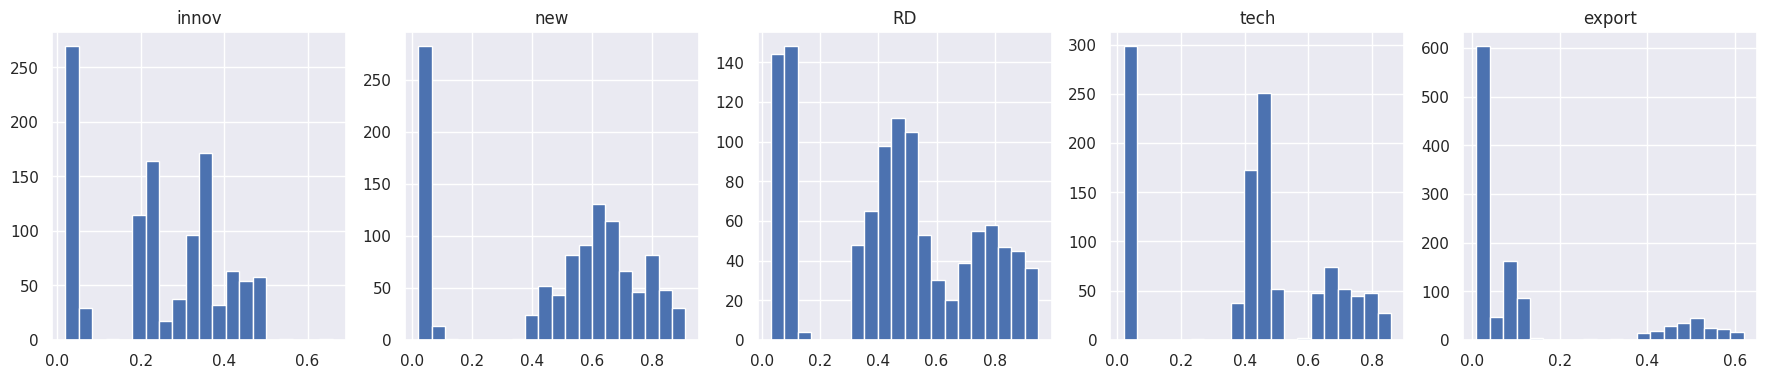

In [7]:
cols = list(data.columns)
fig, ax = plt.subplots(1, 5, figsize=(22, 4))
for i, c in enumerate(cols):
  ax[i].hist(data[c], bins=20)
  ax[i].set_title(c)
plt.show()

По гистограммам видно, что есть большая вероятность существования нескольких кластеров (на первый взгяд 3 кластера)

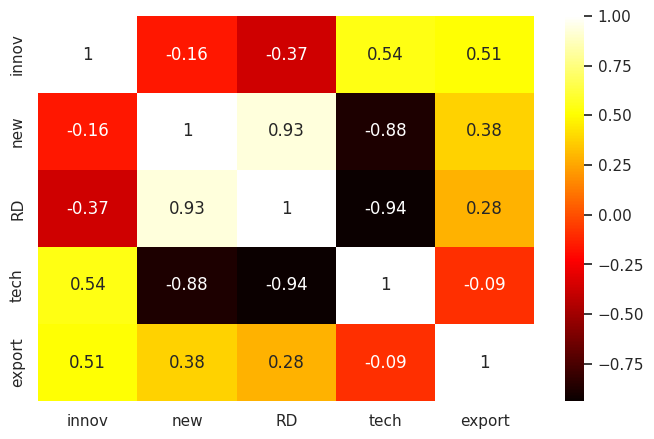

In [8]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap='hot')
plt.show()

Матрица корреляции показывает сильную связь между тремя признаками `new`,`RD` и `tech`, так что есть возможность в силу их линейной зависимости выкинуть из рассмотрения.

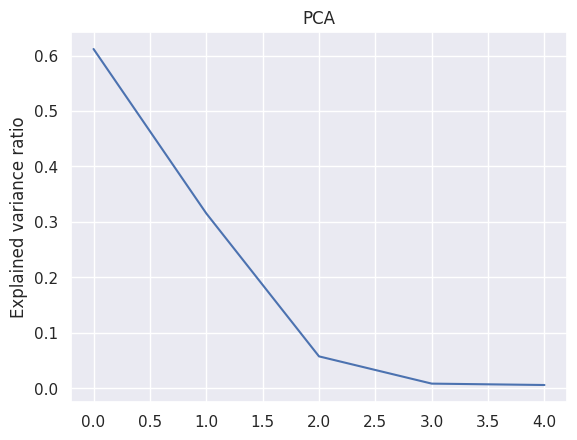

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA().fit(StandardScaler().fit_transform(data))
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained variance ratio')
plt.title('PCA')
plt.show()

Из PCA видна возможность уменьшить размерность пространства до 2 (93%).

# Иерархическая кластеризация

Перед выполнением кластеризации хорошей практикой является выполнение стандартизации входных данных.

In [20]:
norm_data = StandardScaler().fit_transform(data)
pca_data = PCA(n_components=2).fit_transform(norm_data)

In [11]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn import manifold

In [12]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Посмотрим на распредление данных после PCA

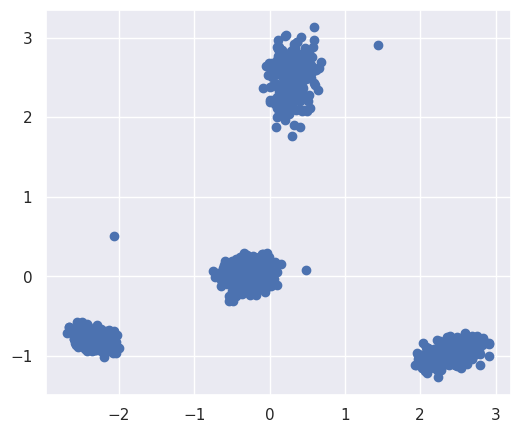

In [28]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# axis = [(0, 1), (1, 2), (0, 2)]
# for i, c in enumerate(axis):
#   ax[i].scatter(pca_data[:, c[0]], pca_data[:, c[1]])
#   ax[i].set_title(f'Axis {c}')
# plt.plot()
plt.figure(figsize=(6, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1])
plt.show()


Четко наблюдается 4 кластера с 3 выбросными точками.

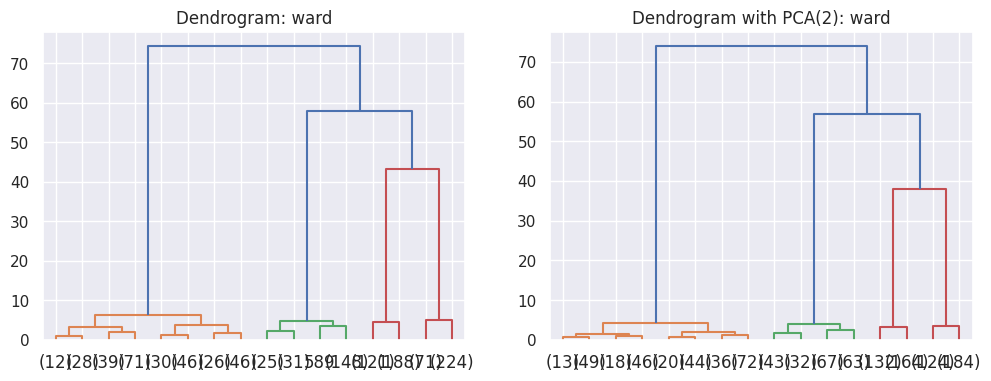

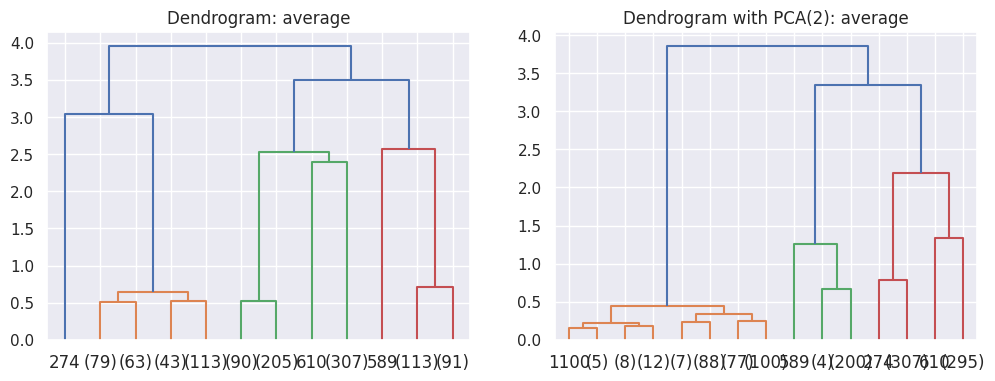

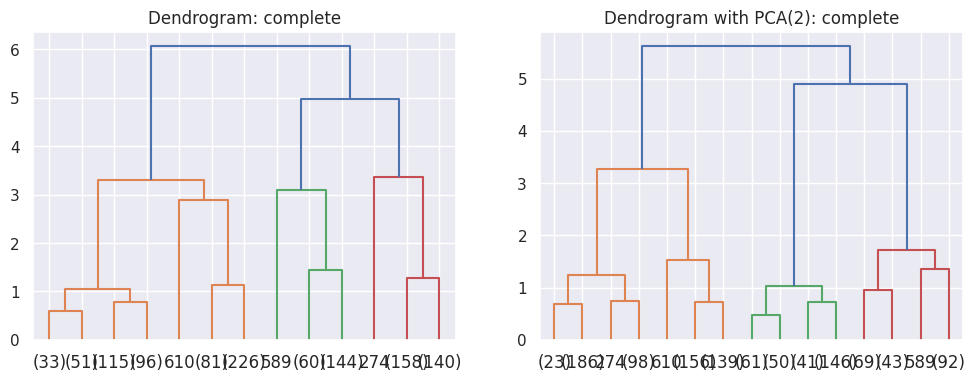

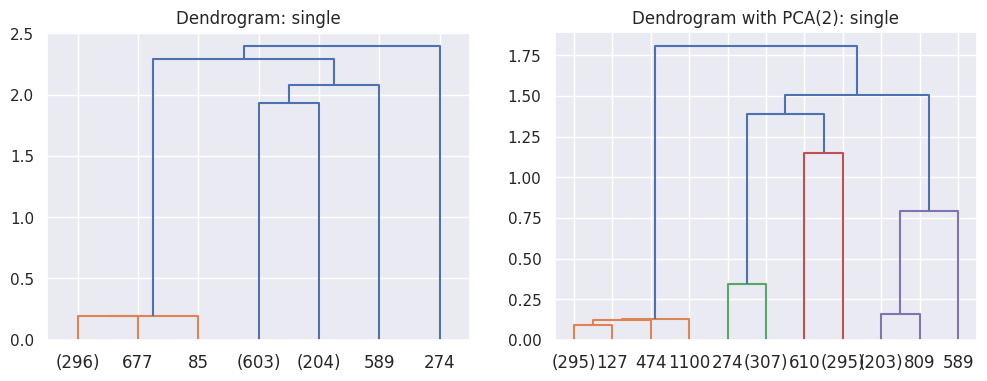

In [23]:
for linkage in ('ward', 'average', 'complete', 'single'):

    hierar_clf = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage).fit(norm_data)
    hierar_clf_pca = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage).fit(pca_data)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_title(f"Dendrogram: {linkage}")
    plot_dendrogram(hierar_clf, truncate_mode="level", p=3, ax=ax[0])
    ax[1].set_title(f"Dendrogram with PCA(2): {linkage}")
    plot_dendrogram(hierar_clf_pca, truncate_mode="level", p=3, ax=ax[1])
    plt.show()

Лучше всего работает расстояние по `ward`, что логично + оно используется по дефолту во многих методах кластеризации. Число кластеров в районе 3+.

#KMeans

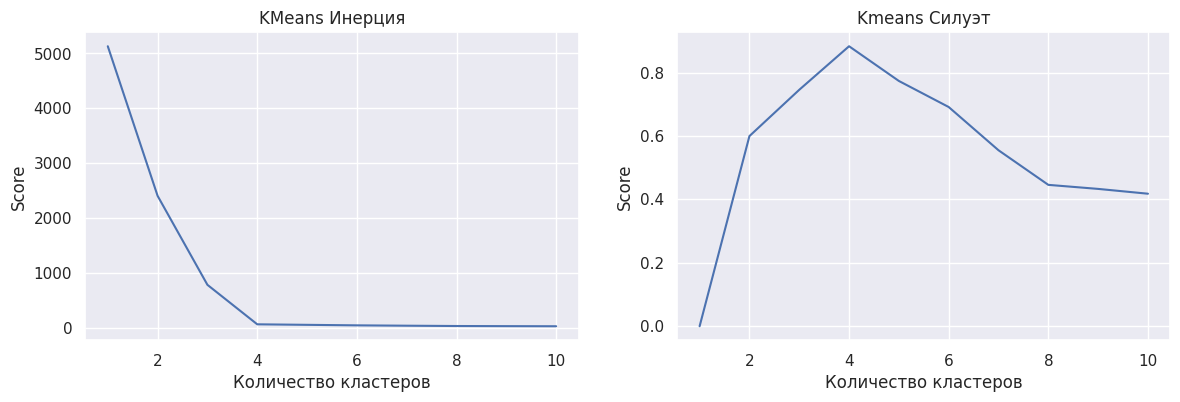

In [24]:
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings("ignore")

inertia = []
silhouette_avg = [0]
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_data)
    if i != 1:
      silhouette_avg.append(silhouette_score(pca_data, cluster_labels))
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(np.arange(1, 11), inertia)
ax[0].set_title('KMeans Инерция')
ax[0].set_xlabel('Количество кластеров')
ax[0].set_ylabel('Score')
ax[1].plot(np.arange(1, 11), silhouette_avg)
ax[1].set_title('Kmeans Cилуэт')
ax[1].set_xlabel('Количество кластеров')
ax[1].set_ylabel('Score')
plt.show()

Оптимальное количество кластеров по методу локтя 4, плюс при этом числе наблюдается пик метрики силуэта.

# DBSCAN

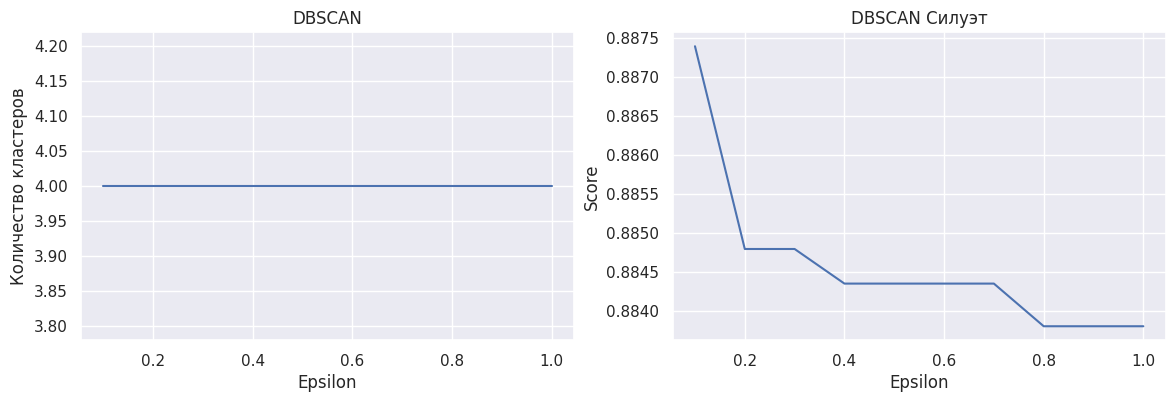

In [25]:
silhouette_avg = []
clusters = []
for eps in np.arange(0.1, 1.1, 0.1):
    dbscan = DBSCAN(eps=eps)
    cluster_labels = dbscan.fit_predict(pca_data)
    not_noise = (cluster_labels != -1)
    silhouette_avg.append(silhouette_score(pca_data[not_noise], cluster_labels[not_noise]))
    clusters.append(len(np.unique(cluster_labels)) - 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].plot(np.arange(0.1, 1.1, 0.1), clusters)
ax[0].set_title('DBSCAN')
ax[0].set_ylabel('Количество кластеров')
ax[0].set_xlabel('Epsilon')
ax[1].plot(np.arange(0.1, 1.1, 0.1), silhouette_avg)
ax[1].set_title('DBSCAN Cилуэт')
ax[1].set_xlabel('Epsilon')
ax[1].set_ylabel('Score')
plt.show()

Тут тоже выделяется 4 кластера, при этом радиус DBSCAN особо не сильно влияет на силуэт.

# Результаты с оптимальными параметрами KMeans, DBSCAN

In [31]:
def plot_results(data, pca_data, labels, n_clusters=4):
  # fig, ax = plt.subplots(1, 3, figsize=(12, 4))
  # axis = [(0, 1), (1, 2), (0, 2)]
  # for i, axi in enumerate(axis):
  #   ax[i].scatter(pca_data[:, axi[0]], pca_data[:, axi[1]], c=labels)
  #   ax[i].set_title(f'Axis {c}')
  # plt.plot()
  plt.figure(figsize=(6, 5))
  plt.scatter(pca_data[:, 0], pca_data[:, 1], c=labels)
  plt.show()

  data['labels'] = labels
  mean_features = data.groupby('labels')[cols].mean()
  plt.figure(figsize=(10, 4))
  for i in range(4):
    plt.plot(range(len(cols)), mean_features.iloc[i, :])
  plt.xticks(range(len(cols)), cols)
  plt.show()

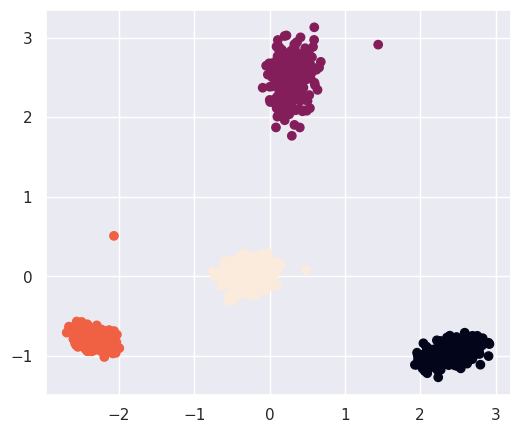

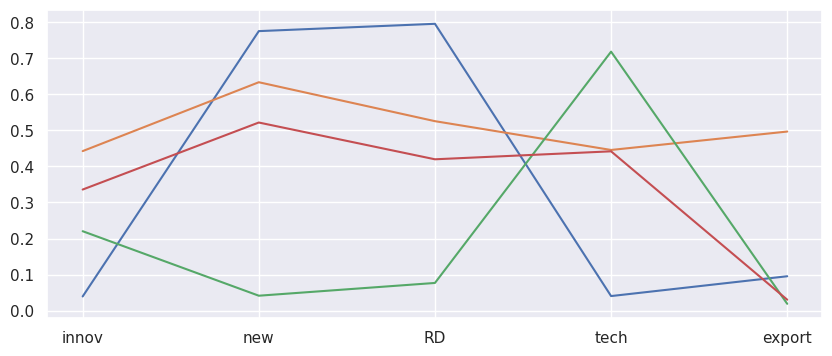

In [32]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels_kmeans = kmeans.fit_predict(pca_data)
plot_results(data.copy(), pca_data, cluster_labels_kmeans)

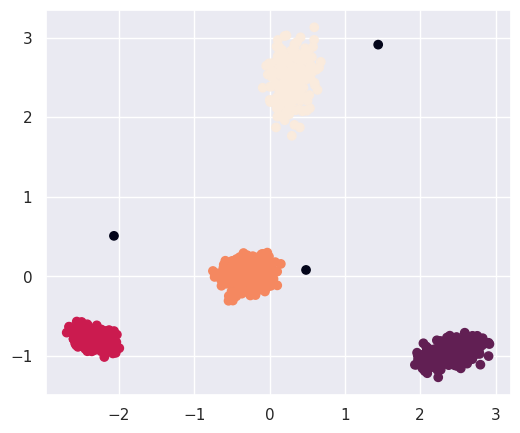

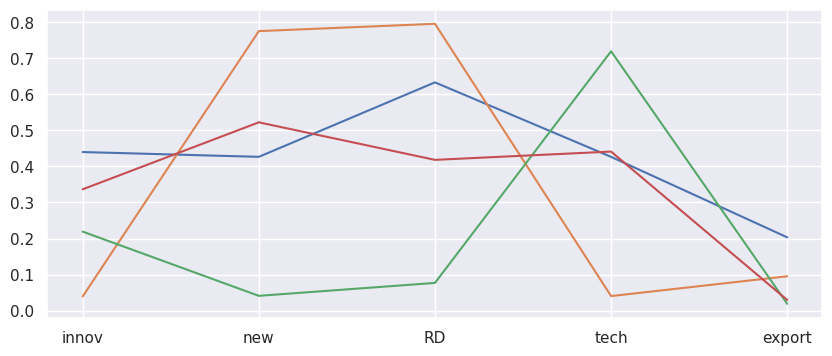

In [33]:
dbscan = DBSCAN(eps=0.3)
cluster_labels_dbscan = dbscan.fit_predict(pca_data)
plot_results(data.copy(), pca_data, cluster_labels_dbscan)

Выведем noise предприятия.

In [37]:
data[cluster_labels_dbscan == -1]

,innov,new,RD,tech,export
274,0.12,0.36,0.90,0.65,0.26
589,0.66,0.79,0.95,0.23,0.34
610,0.54,0.13,0.05,0.40,0.01


In [36]:
data2 = data.copy()
data2['labels'] = cluster_labels_dbscan
data2.groupby('labels')[cols].mean()

,innov,new,RD,tech,export
labels,,,,,
-1,0.440000,0.426667,0.633333,0.426667,0.203333
0,0.039262,0.775537,0.795839,0.040336,0.095302
1,0.219220,0.041017,0.076814,0.719593,0.018881
2,0.336612,0.522443,0.418306,0.441303,0.029511
3,0.441520,0.632941,0.523578,0.446814,0.497598


# Выводы

В принципе KMeans и DBSCAN дали похожие результаты, но DBCSAN нашел шумовые предприятие, поэтому среднии значения признаков немного поменялись. Дальнейший анализ будем проволить по результатам DBSCAN.

`Синий кластер` и `красный кластер` довольно похожи, вес их инновационной продукции от общего числа продаж довольно высок (30-40%), они продают 40-50% инновационной продкции, которая новая для рынка, тратят 40% от общего числа затрат на приобретение техн. инновации в неовещ. форме (патенты и т.д.), но при этом `cиний` имеет в 1.5 раза больше трат на R&D (60%) и в 4 раза больше продает по экспорту (20%, что является наиболшим числом среди всех кластеров), чем `красный`.

`Желтый кластер` - продает мало инновационной продукции от общего числа своих продаж (4%, наименьшее число среди всех), мало тратят на покупку неовещ. техн...(4%, меньше всех), но при этом имеют наибольшие значения (80%) R&D и новой продукции на рынке, то есть они сами разрабатывают новую продукцию с минимальным заимствованием и иммеют внушительный показатель по экспорту (10%).

`Зеленый кластер` прямая противоположность `желтому`, они сами ничего не нового разрабатывают ([4% `new`, 8% `RD`] меньше всех), а только закупает из вне (70%, больше всех) и с небольшими доработками поставляют инновационную продукцию на рынок, которая не является новой для рынка (20%), при этом они обладают наименьшей долей экспорта из всех кластеров (2%).